In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.decomposition import PCA

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
import optuna

file_path = '../cleaned_data3.csv'  # <-- แก้เอง

# Use existing df_all in the notebook if available, otherwise read CSV
if 'df_all' in globals():
    df_all_local = df_all.copy()
    print("Using existing df_all from notebook variables")
else:
    df_all_local = pd.read_csv(file_path)
    print(f"Loaded df_all from {file_path}")

# If the dataset is in long format (date_month, ind_code, value) pivot to wide.
# If it's already wide (like the provided cleaned_data2.csv), skip pivot.
if 'ind_code' in df_all_local.columns and 'value' in df_all_local.columns:
    # ensure date column name matches expectation
    if 'date_month' not in df_all_local.columns and 'year_month' in df_all_local.columns:
        df_all_local = df_all_local.rename(columns={'year_month': 'date_month'})
    # ลบ whitespace จาก ind_code
    df_all_local['ind_code'] = df_all_local['ind_code'].astype(str).str.strip()

    print("Available indicators:")
    print(sorted(df_all_local['ind_code'].unique()))
    print()

    df = df_all_local.pivot_table(
        index='date_month',
        columns='ind_code',
        values='value'
    ).reset_index()
else:
    # assume wide format; try to find date column
    if 'date_month' in df_all_local.columns:
        df = df_all_local.copy()
        date_col = 'date_month'
    elif 'year_month' in df_all_local.columns:
        df = df_all_local.copy().rename(columns={'year_month': 'date_month'})
        date_col = 'date_month'
    else:
        raise KeyError("No 'ind_code' column and no recognized date column ('date_month' or 'year_month') found in df_all.")

    print(f"Data treated as wide format. Columns: {sorted(df.columns.tolist())}\n")

print(f"Data loaded: {df.shape}")

# เตรียมข้อมูล
df['date_month'] = pd.to_datetime(df['date_month'], infer_datetime_format=True)
df = df.set_index(['date_month']).sort_index()
df = df.asfreq('MS')  # ตั้งความถี่เป็น Monthly Start

print("Data preparation completed\n")
df.info()

test_size = 18
train_data = df[:-test_size]
test_data = df[-test_size:]

print("\nTrain data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

df


Loaded df_all from ../cleaned_data3.csv
Data treated as wide format. Columns: ['china_pmi', 'china_pmi_lag12', 'china_pmi_lag6', 'china_pmi_ma12', 'china_pmi_ma6', 'china_pmi_std12', 'china_pmi_std6', 'date_month', 'domestic_consumption', 'exchange_rate_usd', 'exchange_rate_usd_pct12', 'exchange_rate_usd_pct6', 'export_volume', 'import_volume', 'is_season', 'month', 'oil_price_thb', 'oil_price_thb_lag12', 'oil_price_thb_lag6', 'oil_price_thb_ma12', 'oil_price_thb_ma6', 'oil_price_thb_pct12', 'oil_price_thb_pct6', 'oil_price_thb_std12', 'oil_price_thb_std6', 'quarter', 'stock', 'stock_lag12', 'stock_lag6', 'thai_price', 'thai_price_lag12', 'thai_price_lag6', 'thai_price_ma12', 'thai_price_ma6', 'thai_price_pct12', 'thai_price_pct6', 'thai_price_std12', 'thai_price_std6', 'world_price_thb_kg', 'world_price_thb_kg_lag12', 'world_price_thb_kg_lag6', 'world_price_thb_kg_ma12', 'world_price_thb_kg_ma6', 'world_price_thb_kg_pct12', 'world_price_thb_kg_pct6', 'world_price_thb_kg_std12', 'world

c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\bankw\AppData\Local\Temp\ipykernel_18688\2908036797.py:47: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date_month'] = pd.to_datetime(df['date_month'], infer_datetime_format=True)


,domestic_consumption,import_volume,export_volume,stock,exchange_rate_usd,china_pmi,thai_price,oil_price_thb,world_price_thb_kg,month,...,china_pmi_ma12,china_pmi_std12,thai_price_pct6,thai_price_pct12,world_price_thb_kg_pct6,world_price_thb_kg_pct12,oil_price_thb_pct6,oil_price_thb_pct12,exchange_rate_usd_pct6,exchange_rate_usd_pct12
date_month,,,,,,,,,,,,,,,,,,,,,
2007-01-01,30652000,55000,267567000.0,2.806710e+08,36.1800,54.8,65.12,2103.505200,75.168260,1,...,54.991667,1.568704,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2007-02-01,26790000,44000,237979000.0,2.490050e+08,35.7500,55.1,72.91,2208.992500,81.465325,2,...,54.991667,1.568704,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2007-03-01,31717000,119000,230410000.0,2.173390e+08,35.0600,53.1,69.62,2309.402200,78.626062,3,...,54.991667,1.568704,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2007-04-01,27788000,184000,180185000.0,1.785750e+08,34.8700,56.1,72.84,2291.307700,80.907121,4,...,54.991667,1.568704,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2007-05-01,32905000,91000,178103000.0,2.092150e+08,34.6200,58.6,71.47,2216.026200,82.004049,5,...,54.991667,1.568704,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-01,109368000,63000,369222000.0,1.050152e+09,33.9385,50.2,67.91,2367.549760,82.482469,2,...,49.858333,0.541812,-4.927901,-0.556450,-0.770023,10.757094,-7.819097,-16.007660,-2.810989,-5.773502
2025-03-01,95398000,111000,369396000.0,9.991970e+08,33.9768,50.5,66.56,2428.661664,81.367993,3,...,49.833333,0.499697,-15.274949,-16.591479,-10.363973,-10.362344,6.261304,-19.139439,1.340698,-5.915321
2025-04-01,69306000,73000,317716000.0,8.799700e+08,33.9148,49.0,59.69,1974.180508,73.920391,4,...,49.716667,0.518448,-21.789832,-22.288764,-16.509908,-15.814324,-14.981222,-34.788767,1.157887,-8.215834


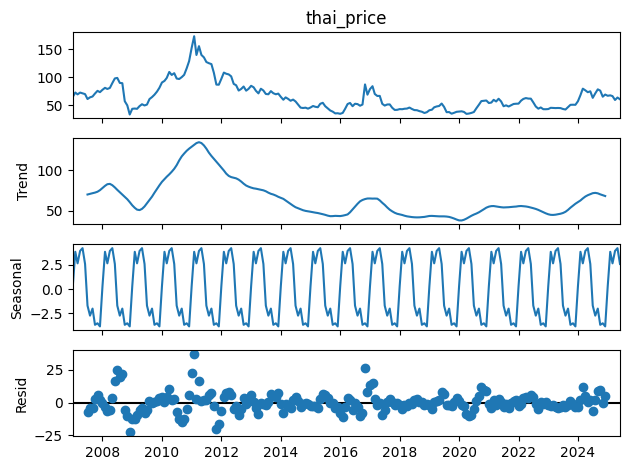

In [3]:
result = seasonal_decompose(df['thai_price'], model='additive', period=12)
result.plot()
plt.show()


Available columns: ['domestic_consumption', 'import_volume', 'export_volume', 'stock', 'exchange_rate_usd', 'china_pmi', 'thai_price', 'oil_price_thb', 'world_price_thb_kg', 'month', 'quarter', 'year', 'is_season', 'thai_price_lag6', 'thai_price_lag12', 'world_price_thb_kg_lag6', 'world_price_thb_kg_lag12', 'oil_price_thb_lag6', 'oil_price_thb_lag12', 'china_pmi_lag6', 'china_pmi_lag12', 'stock_lag6', 'stock_lag12', 'thai_price_ma6', 'thai_price_std6', 'thai_price_ma12', 'thai_price_std12', 'world_price_thb_kg_ma6', 'world_price_thb_kg_std6', 'world_price_thb_kg_ma12', 'world_price_thb_kg_std12', 'oil_price_thb_ma6', 'oil_price_thb_std6', 'oil_price_thb_ma12', 'oil_price_thb_std12', 'china_pmi_ma6', 'china_pmi_std6', 'china_pmi_ma12', 'china_pmi_std12', 'thai_price_pct6', 'thai_price_pct12', 'world_price_thb_kg_pct6', 'world_price_thb_kg_pct12', 'oil_price_thb_pct6', 'oil_price_thb_pct12', 'exchange_rate_usd_pct6', 'exchange_rate_usd_pct12']
Selected external factors: ['world_price_thb

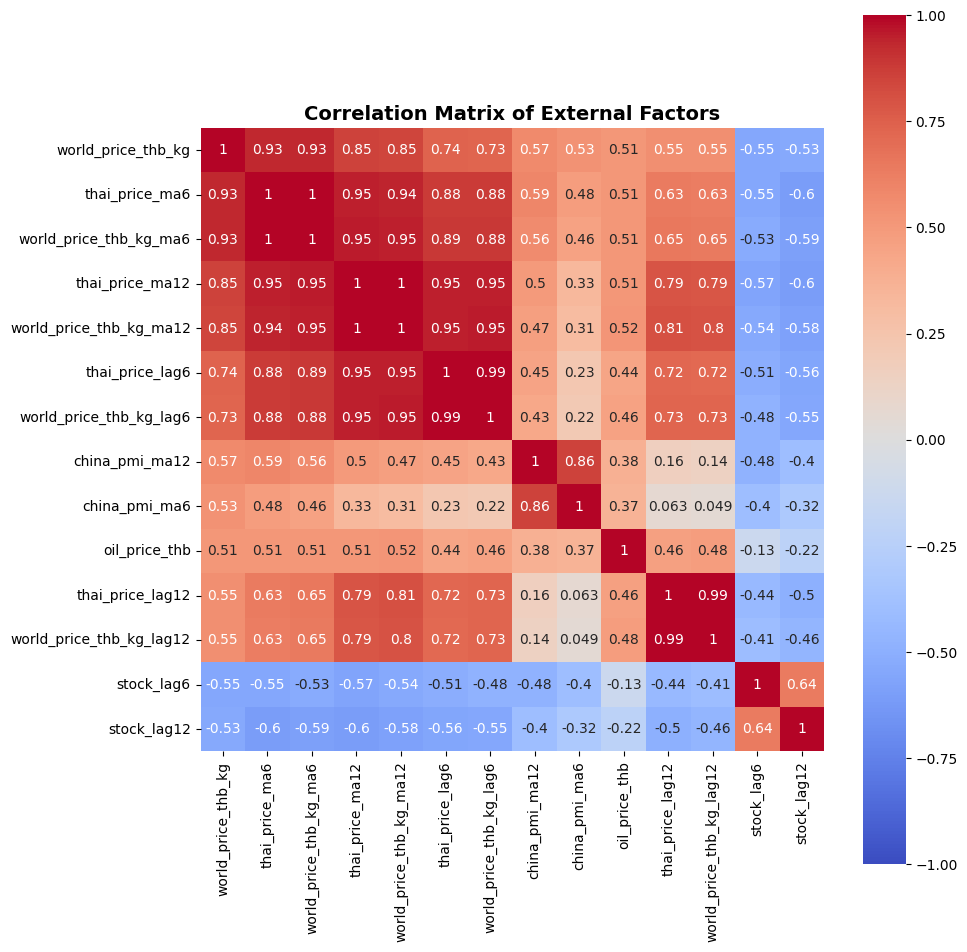

In [4]:
external_factors = [
    'world_price_thb_kg', 'thai_price_ma6', 'world_price_thb_kg_ma6', 'thai_price_ma12', 'world_price_thb_kg_ma12', 'thai_price_lag6', 'world_price_thb_kg_lag6',
    'china_pmi_ma12', 'china_pmi_ma6', 'oil_price_thb', 'thai_price_lag12', 'world_price_thb_kg_lag12', 'stock_lag6', 'stock_lag12'
]

print("Available columns:", df.columns.tolist())
print("Selected external factors:", [c for c in external_factors if c in df.columns])
print()

#เตรียม X, y
train_exog = train_data[external_factors].copy()
test_exog  = test_data[external_factors].copy()

X_train_raw = train_exog.copy()
X_test_raw  = test_exog.copy()
y_train = train_data['thai_price']
y_test  = test_data['thai_price']

mean_trp = y_train.mean()
print(f"Mean Thai Price (train): {mean_trp:.4f}")
print("X_train:", X_train_raw.shape, " X_test:", X_test_raw.shape)

# Scaling (ใช้กับทุกโมเดล Ridge)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test  = scaler.transform(X_test_raw)

# Correlation matrix ของ external factors
corr = train_exog.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    square=True
)
plt.title("Correlation Matrix of External Factors", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [5]:
before_model = Ridge(alpha=1.0, random_state=42)

before_model.fit(X_train, y_train)
pred_before = before_model.predict(X_test)

rmse_before = np.sqrt(mean_squared_error(y_test, pred_before))
mape_before = mean_absolute_percentage_error(y_test, pred_before) * 100

print("=== BEFORE MODEL (Baseline Ridge) ===")
print(f"RMSE : {rmse_before:.4f}")
print(f"MAPE : {mape_before:.2f}%")

=== BEFORE MODEL (Baseline Ridge) ===
RMSE : 2.0488
MAPE : 2.60%


In [6]:
import optuna

def objective_ridge(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1e3, log=True)
    fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])

    model = Ridge(alpha=alpha, fit_intercept=fit_intercept, random_state=42)
    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, pred, squared=False)
    return rmse

study_ridge = optuna.create_study(direction="minimize")
study_ridge.optimize(objective_ridge, n_trials=60)

best_ridge_params = study_ridge.best_params
print("\n=== OPTUNA BEST PARAMS (Ridge) ===")
print(best_ridge_params)

[I 2025-11-27 00:45:47,573] A new study created in memory with name: no-name-d371b9d3-aca7-449f-842f-602436b7091a
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-11-27 00:45:47,611] Trial 0 finished with value: 2.238109013992116 and parameters: {'alpha': 1.8097862026457747, 'fit_intercept': True}. Best is trial 0 with value: 2.238109013992116.
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-11-27 00:45:47,614] Trial 1 finished with value: 2.6637764726678737 and parameters: {'alpha': 3.9133


=== OPTUNA BEST PARAMS (Ridge) ===
{'alpha': 0.00010017612321895042, 'fit_intercept': True}


In [7]:
after_model = Ridge(
    alpha=best_ridge_params["alpha"],
    fit_intercept=best_ridge_params["fit_intercept"],
    random_state=42
)

after_model.fit(X_train, y_train)
pred_after = after_model.predict(X_test)

rmse_after = np.sqrt(mean_squared_error(y_test, pred_after))
mape_after = mean_absolute_percentage_error(y_test, pred_after) * 100

print("=== AFTER MODEL (Optuna Tuned Ridge) ===")
print(f"RMSE : {rmse_after:.4f}")
print(f"MAPE : {mape_after:.2f}%")


=== AFTER MODEL (Optuna Tuned Ridge) ===
RMSE : 1.8396
MAPE : 2.31%


In [8]:
def compute_score(rmse, mape, mean_trp, w_rmse=0.5, w_mape=0.5):
    """
    Unified Score 0–100 จาก RMSE และ MAPE
    """
    nrmse = rmse / mean_trp        # Normalize ด้วย mean ของ TRP
    mape_norm = mape / 100.0
    score = 100 * (1 - (w_rmse*nrmse + w_mape*mape_norm))
    return max(0, min(100, score))

score_before = compute_score(rmse_before, mape_before, mean_trp)
score_after  = compute_score(rmse_after,  mape_after,  mean_trp)

summary_df = pd.DataFrame({
    "Model": ["Before (Baseline Ridge)", "After (Optuna Ridge)"],
    "RMSE": [rmse_before, rmse_after],
    "MAPE (%)": [mape_before, mape_after],
    "Score (0-100)": [score_before, score_after]
})

print("=== COMPARISON: BEFORE vs AFTER (Ridge) ===")
print(summary_df.to_string(index=False))


=== COMPARISON: BEFORE vs AFTER (Ridge) ===
                  Model     RMSE  MAPE (%)  Score (0-100)
Before (Baseline Ridge) 2.048846  2.601046      97.113115
   After (Optuna Ridge) 1.839623  2.309549      97.420859


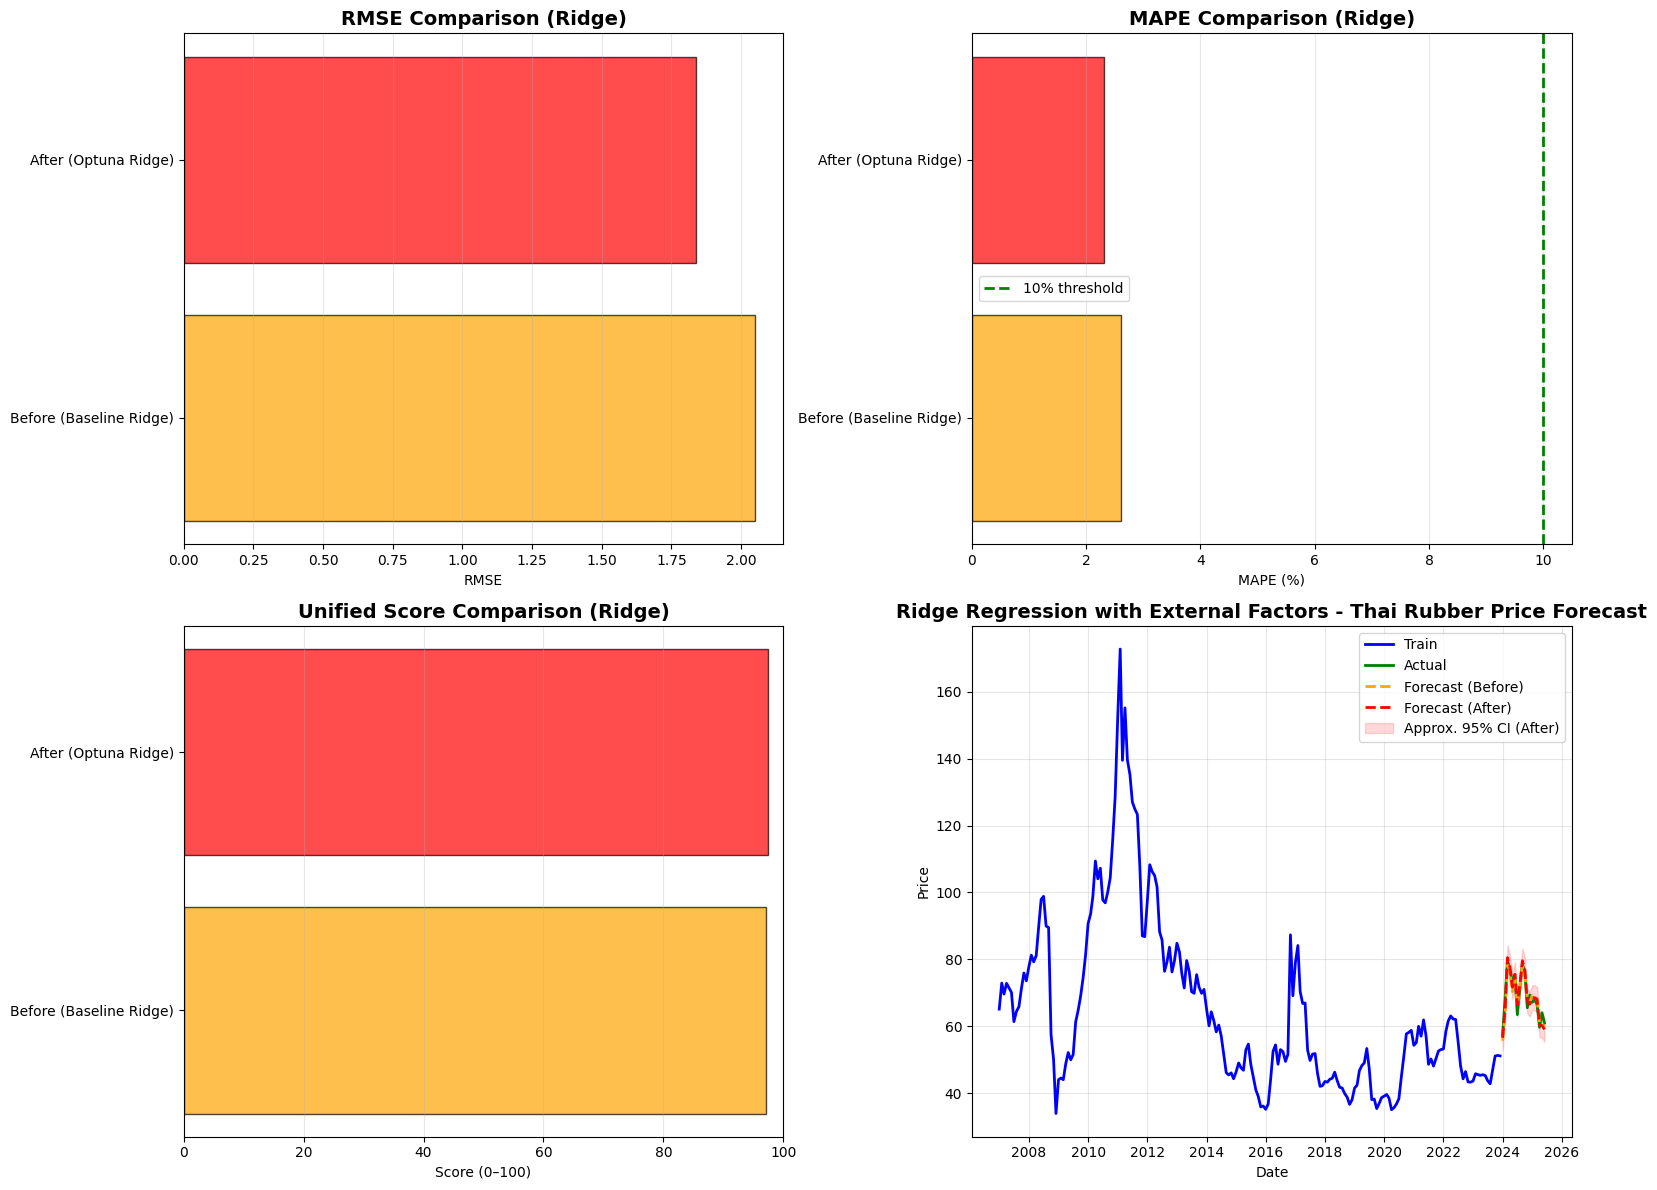

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models = summary_df["Model"].tolist()
rmse_vals = summary_df["RMSE"].tolist()
mape_vals = summary_df["MAPE (%)"].tolist()
score_vals = summary_df["Score (0-100)"].tolist()

#RMSE Comparison
ax = axes[0, 0]
ax.barh(models, rmse_vals, color=["orange", "red"], edgecolor="black", alpha=0.7)
ax.set_xlabel("RMSE")
ax.set_title("RMSE Comparison (Ridge)", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3, axis="x")

#MAPE Comparison
ax = axes[0, 1]
ax.barh(models, mape_vals, color=["orange", "red"], edgecolor="black", alpha=0.7)
ax.axvline(x=10, color="green", linestyle="--", linewidth=2, label="10% threshold")
ax.set_xlabel("MAPE (%)")
ax.set_title("MAPE Comparison (Ridge)", fontsize=14, fontweight="bold")
ax.legend()
ax.grid(True, alpha=0.3, axis="x")

#Score Comparison
ax = axes[1, 0]
ax.barh(models, score_vals, color=["orange", "red"], edgecolor="black", alpha=0.7)
ax.set_xlabel("Score (0–100)")
ax.set_xlim(0, 100)
ax.set_title("Unified Score Comparison (Ridge)", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3, axis="x")

#Forecast Plot (After + Before)
pred_before_series = pd.Series(pred_before, index=test_data.index)
pred_after_series  = pd.Series(pred_after,  index=test_data.index)

ax = axes[1, 1]
ax.plot(train_data.index, train_data['thai_price'], label="Train", color="blue", linewidth=2)
ax.plot(test_data.index,  test_data['thai_price'],  label="Actual", color="green", linewidth=2)
ax.plot(pred_before_series.index, pred_before_series.values,
        label="Forecast (Before)", color="orange", linestyle="--", linewidth=2)
ax.plot(pred_after_series.index, pred_after_series.values,
        label="Forecast (After)", color="red", linestyle="--", linewidth=2)

# CI แบบคร่าว ๆ จาก residual ของ After
residuals = test_data['thai_price'] - pred_after_series
sigma = residuals.std()
upper = pred_after_series + 1.96 * sigma
lower = pred_after_series - 1.96 * sigma
ax.fill_between(pred_after_series.index, lower, upper,
                color="red", alpha=0.15, label="Approx. 95% CI (After)")

ax.set_title("Ridge Regression with External Factors - Thai Rubber Price Forecast",
             fontsize=14, fontweight="bold")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


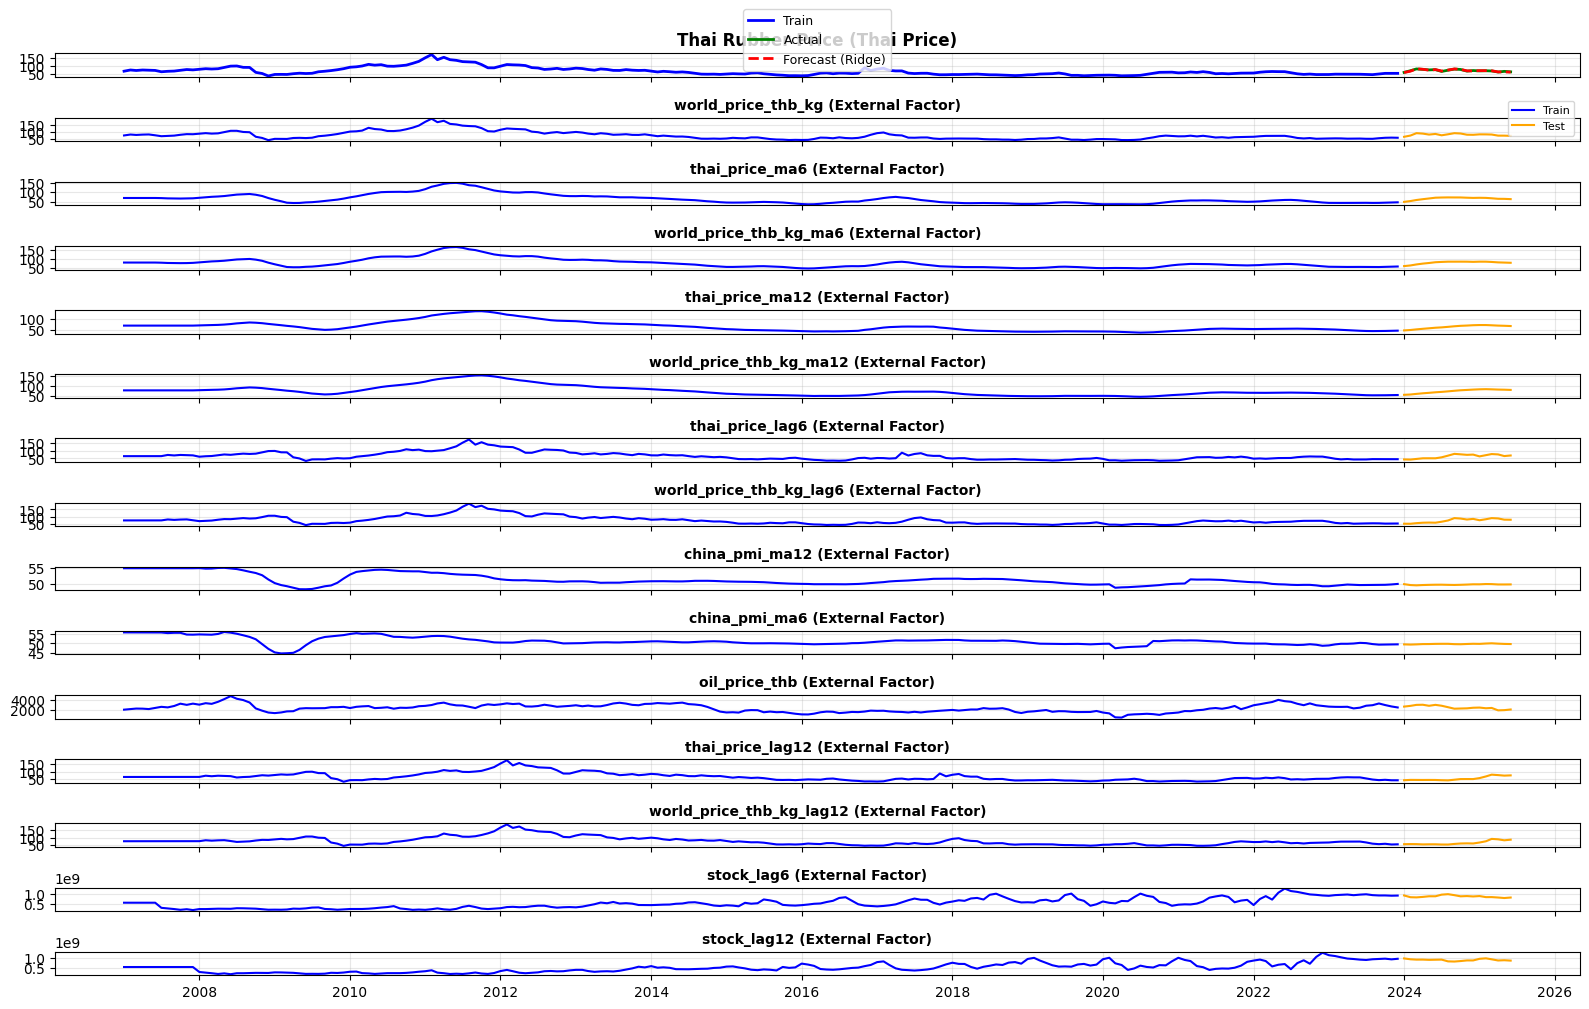

In [10]:
num_factors = len(external_factors)
fig, axes = plt.subplots(num_factors + 1, 1,
                         figsize=(16, 10),
                         sharex=True)

ax0 = axes[0]
ax0.plot(train_data.index, train_data['thai_price'],
         label='Train', color='blue', linewidth=2)
ax0.plot(test_data.index, test_data['thai_price'],
         label='Actual', color='green', linewidth=2)
ax0.plot(pred_after_series.index, pred_after_series.values,
         label='Forecast (Ridge)', color='red', linestyle='--', linewidth=2)
ax0.set_title('Thai Rubber Price (Thai Price)', fontweight='bold')
ax0.legend(fontsize=9)
ax0.grid(True, alpha=0.3)


for i, factor in enumerate(external_factors):
    ax = axes[i+1]
    ax.plot(train_data.index, train_data[factor],
            label='Train', color='blue', linewidth=1.5)
    ax.plot(test_data.index, test_data[factor],
            label='Test', color='orange', linewidth=1.5)
    ax.set_title(f'{factor} (External Factor)', fontweight='bold', fontsize=10)
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


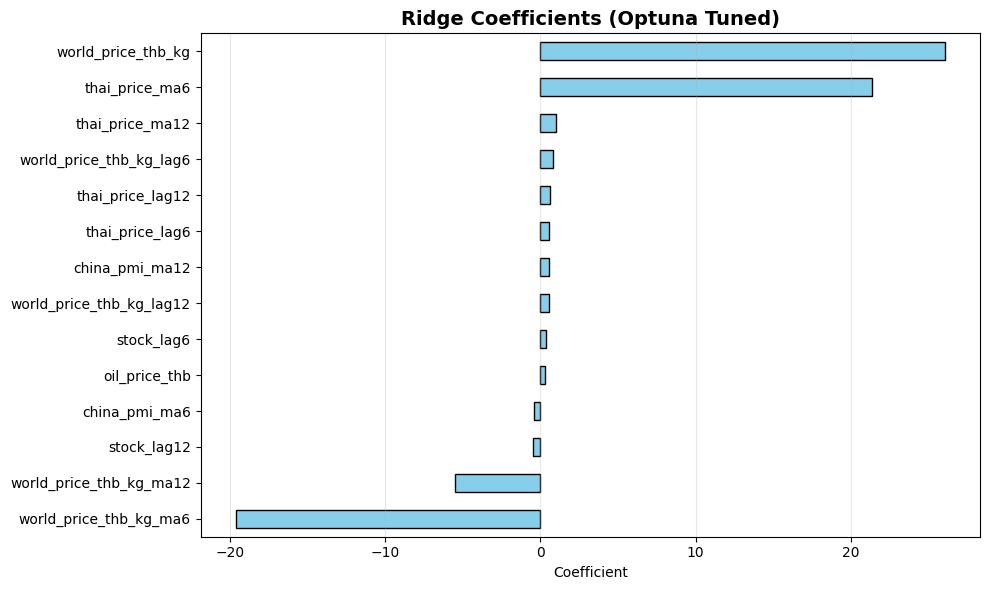

In [11]:
coef_series = pd.Series(after_model.coef_, index=external_factors).sort_values()

plt.figure(figsize=(10, 6))
coef_series.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title("Ridge Coefficients (Optuna Tuned)", fontsize=14, fontweight='bold')
plt.xlabel("Coefficient")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


In [12]:
data = {
    'Model': ['Baseline (Ridge)', 'Optuna Ridge'],
    'RMSE': [rmse_before, rmse_after],
    'MAPE': [mape_before/100, mape_after/100],
    'ACCURACY': [score_before/100, score_after/100]
}

df_comparison = pd.DataFrame(data)

df_comparison['MAPE (%)'] = (df_comparison['MAPE'] * 100).map('{:.2f}%'.format)
df_comparison['ACCURACY (%)'] = (df_comparison['ACCURACY'] * 100).map('{:.2f}%'.format)

df_display = df_comparison[['Model', 'RMSE', 'MAPE (%)', 'ACCURACY (%)']]

print("Performance Comparison (Ridge Regression)\n")
print(df_display.to_string(index=True, col_space=15))


Performance Comparison (Ridge Regression)

                            Model            RMSE        MAPE (%)    ACCURACY (%)
0                Baseline (Ridge)        2.048846           2.60%          97.11%
1                    Optuna Ridge        1.839623           2.31%          97.42%


In [13]:
#Savemodel ใช้ joblib
'''
import joblib

artifacts = {
    "model": after_model,
    "scaler": scaler,
    "features": external_factors
}

joblib.dump(artifacts, "ridge_trp_model.joblib")
print("Saved model artifacts to ridge_trp_model.joblib")
'''

'\nimport joblib\n\nartifacts = {\n    "model": after_model,\n    "scaler": scaler,\n    "features": external_factors\n}\n\njoblib.dump(artifacts, "ridge_trp_model.joblib")\nprint("Saved model artifacts to ridge_trp_model.joblib")\n'